In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Sep  1 01:37:52 2019

@author: betashort
"""

"""
import Library
"""
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from PIL import Image
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')



class DeepInsight(object):
    """

    """
    def __init__(self):
        self.result_points = None
        self.result_rectan = None

    """
    Obtain DeepInsight's Images for Train
    """

    def fit(self, df, method='kpca'):
        '''

        :param df:data
        :param method:decomp method defalt is 'Kernel PCA'
        :param points is decomp result
        :return:
        '''

        '''
        decomp_method
        '''
        sd = StandardScaler()
        sd.fit(df.T)
        train_sd = sd.transform(df.T)

        if method == 'kpca':
            kpca = KernelPCA(n_components=2, kernel='rbf')
            points = kpca.fit_transform(train_sd)

        elif method == 'tsne':
            tsne = TSNE(n_components=2, metric='cosine')
            points = tsne.fit_transform(train_sd)


        #Calculate Convex-Hull
        #output is corner points of 'Minimum Bounding Rectangle Box'

        corner_points = self.__MBRB(points)


        #Transform points
        self.result_points, self.result_rectan = self.__Transform_coor(points, corner_points)


    def fit_transform(self, df, method='kpca'):
        '''

        :param df:data
        :param method:decomp method defalt is 'Kernel PCA'
        :param points is decomp result
        :return:
        '''

        '''
        decomp_method
        '''
        sd = StandardScaler()
        sd.fit(df.T)
        train_sd = sd.transform(df.T)

        if method == 'kpca':
            kpca = KernelPCA(n_components=2, kernel='rbf')
            points = kpca.fit_transform(train_sd)

        elif method == 'tsne':
            tsne = TSNE(n_components=2, metric='cosine')
            points = tsne.fit_transform(train_sd)


        #Calculate Convex-Hull
        #output is corner points of 'Minimum Bounding Rectangle Box'

        corner_points = self.__MBRB(points)


        #Transform points
        self.result_points, self.result_rectan = self.__Transform_coor(points, corner_points)


        #Create Image

        images = self.__create_image(df)

        return images

    """
    Obtain DeepInsight's Images 
    """
    def transform(self, df):

        images = self.__create_image(df)

        return images



    """
    -----------------
    can't access
    -----------------
    """

    """
    Use Convex Hull
    Calculate corner points of Minimum Bounding Rectangle Box with Rotation
    """

    def __MBRB(self, points):
        hull = ConvexHull(points)

        points = hull.points
        hull_points = points[hull.vertices]

        # calculate edge angle arctan2(y/x)
        edge_angles = np.zeros(len(hull_points) - 1)

        for i in range(len(edge_angles)):
            edge_x = hull_points[i + 1, 0] - hull_points[i, 0]
            edge_y = hull_points[i + 1, 1] - hull_points[i, 1]
            edge_angles[i] = abs(math.atan2(edge_y, edge_x) % (math.pi / 2))

        edge_angles = np.unique(edge_angles)

        '''
        # search minimum bounding rectangle
        # min_bbox = (rot_angle, area, width, height, min_x, max_x, min_y, max_y)
        '''
        min_bbox = (0, sys.maxsize, 0, 0, 0, 0, 0)

        for i in range(len(edge_angles)):
            # create Rotation matrix
            R = np.array([[math.cos(edge_angles[i]), math.cos(edge_angles[i] - (math.pi / 2))],
                          [math.cos(edge_angles[i] + (math.pi / 2)), math.cos(edge_angles[i])]])

            rot_points = np.dot(R, hull_points.T)

            # min max
            min_x = np.nanmin(rot_points[0], axis=0)
            max_x = np.nanmax(rot_points[0], axis=0)
            min_y = np.nanmin(rot_points[1], axis=0)
            max_y = np.nanmax(rot_points[1], axis=0)

            # width height
            width = max_x - min_x
            height = max_y - min_y

            area = width * height

            # store the smallest
            if (area < min_bbox[1]):
                min_bbox = (edge_angles[i], area, width, height, min_x, max_x, min_y, max_y)

        angle = min_bbox[0]

        R = np.array([[math.cos(angle), math.cos(angle - (math.pi / 2))],
                      [math.cos(angle + (math.pi / 2)), math.cos(angle)]])

        proj_points = np.dot(R, hull_points.T)

        min_x = min_bbox[4]
        max_x = min_bbox[5]
        min_y = min_bbox[6]
        max_y = min_bbox[7]

        center_x = (min_x + max_x) / 2
        center_y = (min_y + max_y) / 2
        center_point = np.dot([center_x, center_y], R)

        corner_points = np.zeros((4, 2))
        corner_points[0] = np.dot([max_x, min_y], R)
        corner_points[1] = np.dot([min_x, min_y], R)
        corner_points[2] = np.dot([min_x, max_y], R)
        corner_points[3] = np.dot([max_x, max_y], R)

        return corner_points

    """
    Transform Coordinate for Cartecian
    """

    def __Transform_coor(self, points, corner_points):
        rectan = np.vstack((corner_points, corner_points[0]))
        Gr = (corner_points[1, 1] - corner_points[2, 1]) / (corner_points[1, 0] - corner_points[2, 0])

        theta = math.atan(Gr)

        R_coor = np.array([[math.cos(theta), math.sin(theta)],
                           [-math.sin(theta), math.cos(theta)]])

        result_points = np.dot(R_coor, (points).T).T
        result_rectan = np.dot(R_coor, rectan.T).T

        return result_points, result_rectan

    """
    Create_Images
    """

    def __create_image(self, df):
        result_points = self.result_points
        result_rectan = self.result_rectan

        images = []

        rr_p = abs(((result_points - result_rectan[3]) * 100).astype(int))
        #rr_cp = abs(((result_rectan - result_rectan[3]) * 100).astype(int))

        for n in range(df.shape[0]):
            deepinsight = np.zeros((rr_p[:, 0].max() + 1, rr_p[:, 1].max() + 1))
            count_table = np.ones((rr_p[:, 0].max() + 1, rr_p[:, 1].max() + 1))

            for i, position in enumerate(rr_p):
                px = position[0]
                py = position[1]

                if deepinsight[px, py] != 0:
                    count_table[px, py] += 1

                deepinsight[px, py] += df.iloc[n, i]

            #averaging
            deepinsight = deepinsight / count_table

            #Fill 0 with 1
            deepinsight = np.where(deepinsight == 0, 1, deepinsight)

            '''
            Norm
            '''

            max_v = deepinsight.max()
            min_v = deepinsight.min()
            deepinsight = (deepinsight - min_v) / (max_v - min_v)

            '''
            Resize(120×120)
            '''
            i = Image.fromarray(deepinsight)
            deepinsight = np.asarray(i.resize((120, 120)))

            images.append(deepinsight.T)

        images = np.array(images)

        return images



In [2]:
path = "/Volumes/Buffalo-SSD/Kaggle_Datasets/gene-expression/"

In [3]:
os.listdir(path)

['._actual.csv',
 'actual.csv',
 'data_set_ALL_AML_independent.csv',
 '._data_set_ALL_AML_independent.csv',
 'data_set_ALL_AML_train.csv',
 '._data_set_ALL_AML_train.csv']

In [4]:
train = pd.read_csv(path+'data_set_ALL_AML_train.csv')
test = pd.read_csv(path+'data_set_ALL_AML_independent.csv')
actual = pd.read_csv(path+'actual.csv')

In [5]:
def process1(df, actural, target):
    df1 = [col for col in df.columns if "call" not in col]
    df = df[df1]
    df = df.T
    df2 = df.drop(['Gene Description','Gene Accession Number'],axis=0)
    df2.index = pd.to_numeric(df2.index)
    df2.sort_index(inplace=True)
    if target == 'train':
        df2['cat'] = list(actual[:38]['cancer'])
    elif target == 'test':
        df2['cat'] = list(actual[38:]['cancer'])
    dic = {'ALL':0,'AML':1}
    df2.replace(dic,inplace=True)
    return df, df2

In [6]:
%time
train_df, train_df2 = process1(train, actual, 'train')
test_df, test_df2 = process1(test, actual, 'test')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [7]:
y = train_df2['cat'].values
test_y = test_df2['cat'].values

train_df3 = train_df2.drop('cat', axis=1)
test_df3 = test_df2.drop('cat', axis=1)

sd = StandardScaler()
sd.fit(train_df3.T)
train_sd = sd.transform(train_df3.T)

In [8]:
deepinsight = DeepInsight()

In [9]:
%%time
train_images = deepinsight.fit_transform(train_df3)

CPU times: user 5.87 s, sys: 292 ms, total: 6.16 s
Wall time: 4.71 s


In [38]:
train_images.shape

(38, 120, 120)

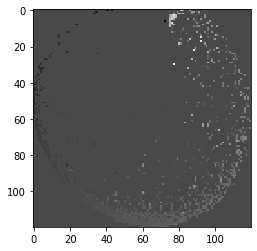

In [39]:
plt.imshow(train_images[0], cmap='gray')